# Decorators for intervals

**genominterv** provides decorators for various tasks to reduce boilerplate code.

To make it easy to create other interval functions that work across chromosomes, the module provides a genomic decorator that can be applied to functions that operate lists of `(start, end)` tuples. Applying the decorator changes the signature of a function to make it operate on DataFrames that include `chrom`, `start`, and `end` columns. 

Here is an example function that shifts the interval coordinates by 1000bp:

In [1]:
#| echo: false
import pandas as pd
import genominterv
%config InlineBackend.figure_format = 'svg'

In [2]:
intervals = pd.DataFrame(dict(chrom=['chr1', 'chr2', 'chr2'], start=[10, 20, 30], end=[15, 25, 35]))
intervals

,chrom,start,end
0,chr1,10,15
1,chr2,20,25
2,chr2,30,35


Create a function that shifts intervals three bases to the right:

In [3]:
from genominterv.decorators import genomic

@genomic
def shift_three(interv):
    return [(start+3, end+3) for (start, end) in interv]

shifted = shift_three(intervals)
shifted

,start,end,chrom
0,13,18,chr1
1,23,28,chr2
2,33,38,chr2


## Bootstrap decorator

The bootstrap decorator turns a function producing a statistic into one that also produces a p-value. Only required argument to bootstrap is the name of the chromosome assembly used. The decorator works on any function that takes two sets of intervals. Here it is used with the [](`~genominterv.stats.jaccard_stat`) statistic to make a `jaccard_test` function that produce a p-value for the significane of overlap between two sets.

In [4]:
annot = pd.DataFrame(dict(chrom=['chr1', 'chr2', 'chr3'], start=[30_000_000, 120_000_000, 120_000_000], 
                                        end=[60_000_000, 100_000_000, 150_000_000]))
query = pd.DataFrame(dict(chrom=['chr1', 'chr3'], start=[20_000_000, 110_000_000], 
                          end=[50_000_000, 160_000_000]))

In [5]:
from genominterv.decorators import bootstrap
from genominterv.stats import jaccard_stat

@bootstrap('hg38', samples=1000)
def jaccard_test(query, annot):
    return jaccard_stat(query, annot)

stat, p_value = jaccard_test(query, annot)
stat, p_value

(0.5555555555555556, 0.014)

The bootstrapping shuffles and repositions the intervals of the query argument for each chromosome independently. 

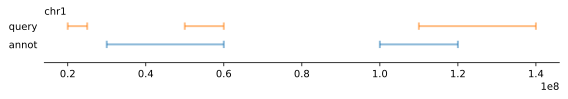

In [6]:
#| echo: false
#| label: fig-intervals
#| fig-cap: "Example of intervals"

query = pd.DataFrame(dict(chrom=['chr1', 'chr1', 'chr1'], start=[20_000_000, 50_000_000, 110_000_000],
                            end=[25_000_000, 60_000_000, 140_000_000]))
annot = pd.DataFrame(dict(chrom=['chr1', 'chr1'], start=[30_000_000, 120_000_000],
                            end=[60_000_000, 100_000_000]))

from genominterv.intervals import _plot_intervals
_plot_intervals(annot=annot, query=query)

For the above set of intervals, the first ten bootstraps could be the ones shown below:

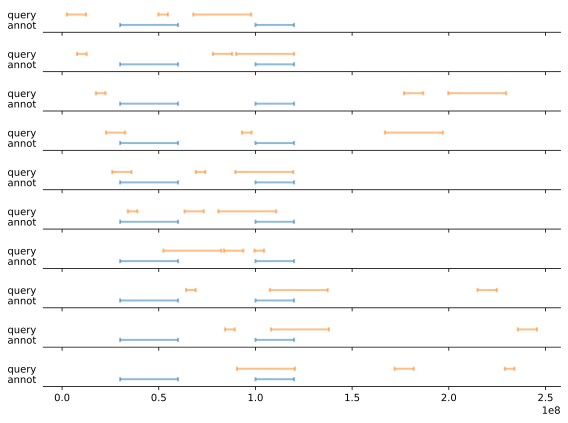

In [7]:
#| echo: false
#| label: fig-boots
#| fig-cap: "Ten bootstraps"

import numpy as np
import matplotlib
matplotlib.rcParams['lines.solid_capstyle'] = 'butt'


def _plot_boots(query_bootstraps=None, annot=None, **kwargs):

    import matplotlib.pyplot as plt

    fig, _axes = plt.subplots(len(query_bootstraps), 1, figsize=(8, 6), sharex=True)

    for i, query in enumerate(query_bootstraps):
        query = pd.DataFrame().from_records(query, columns=['start', 'end'])
        axes = _axes[i]
        axes.hlines(np.repeat(0, annot.index.size), annot.start.tolist(), annot.end.tolist(), alpha=0.5, lw=2, colors='C0')
        axes.hlines(np.repeat(1, query.index.size), query.start.tolist(), query.end.tolist(), alpha=0.5, lw=2, colors='C1')
        delta = 0.2
        axes.vlines(query.start.tolist(), 1-delta, 1+delta, alpha=0.5, lw=2, colors='C1')
        axes.vlines(query.end.tolist(), 1-delta, 1+delta, alpha=0.5, lw=2, colors='C1')
        axes.vlines(annot.start.tolist(), 0-delta, 0+delta, alpha=0.5, lw=2, colors='C0')
        axes.vlines(annot.end.tolist(), 0-delta, 0+delta, alpha=0.5, lw=2, colors='C0')

        axes.spines['top'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.spines['right'].set_visible(False)

        axes.set_yticks([0, 1], ['annot', 'query'])
        axes.tick_params(axis='y', which='both', left=False)
        axes.set_ylim(-0.7, 1.7)
#        axes.set_xlim(query.start.min()-delta, query.end.max()+delta)

    plt.tight_layout()
    plt.show()

from genominterv.decorators import bootstrap

@bootstrap('hg38', samples=10, return_boot=True)
def jaccard_test(query, annot):
    return list(zip(query.start, query.end))

stat, p_value, boot = jaccard_test(query, annot)
#print(list(zip(query.start, query.end)))

stat, p_value, boot

from genominterv.intervals import _plot_intervals
_plot_boots(annot=annot, query_bootstraps=boot)
